# Running a Miner:
* [Init Bittensor](#Init-Bittensor)
    * [Wallet](#Wallet)
    * [Config](#Config)
    * [Metagraph](#Metagraph)
    * [Subscription](#Subscription)


* [Nucleus](#Nucleus)
    * [GPT2-Nucleus](#GPT2-Nucleus)
    * [Test-Nucleus](#Test-Nucleus)
    
    
* [Training](#Training)
    * [Training-Loop](#Training-Loop)
    * [Training-Thread-Runners](#Training-Thread-Runners)
    

* [Serving](#Serving)
    * [Serving-Loop](#Serving-Loop)
    * [Serving-Thread-Runners](#Serving-Thread-Runners)
    * [Test-Serving](#Test-Serving)
    
    
* [Transactions](#Transactions)
    * [Unstaking-Funds](#Unstaking-Funds)
    * [Staking-Funds](#Staking-Funds)
    * [Transfering-Funds](#Transfering-Funds)

   

In [9]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%autoreload 2

In [69]:
import bittensor
import os
import torch
import torch.multiprocessing as mp 
import time
from loguru import logger
from termcolor import colored
import nest_asyncio 
nest_asyncio.apply()
logger.remove()

# **Init Bittensor** <a class="anchor" id="Init-Bittensor"></a>

## **Wallet** <a class="anchor" id="Wallet"></a>

In [12]:
# WALLET: Holds keys to run your miner and control funds.

# *****
# IMPORTANT: Store the mnemonic for **both** your hot and coldkey 
# you will need these to recover your keys if you forget your password or lose access to this machine.
# ******

# Fill in below to name your wallet and keys.
YOUR_WALLET_NAME = 'colab'
YOUR_HOTKEY_NAME = 'colab_hot'

# Fill in below if your need to regenerate your keys.
use_mnemonic = False # Set to true for key regeneration.
coldkey_mnemonic = "<to be filled>".split(' ')
hotkey_mnemonic = "<to be filled>".split(' ')

# Create the wallet object.
wallet = bittensor.Wallet(
    path = "~/.bittensor/wallets/",
    name = YOUR_WALLET_NAME,
    hotkey = YOUR_HOTKEY_NAME
)

# Optionally regens/creates your wallet keys.
if not wallet.has_coldkeypub:
    if use_mnemonic:
        wallet.regenerate_coldkey(mnemonic = coldkey_mnemonic, use_password = True)
    else:
        wallet.create_new_coldkey(n_words = 12, use_password = True )
if not wallet.has_hotkey:
    if use_mnemonic:
        wallet.regenerate_hotkey(mnemonic = hotkey_mnemonic)
    else:
        wallet.create_new_hotkey(n_words = 12)

# Assert before continuing
assert wallet.has_hotkey
assert wallet.has_coldkeypub

Loaded coldkey.pub: 0x3c9cd1679888e5660b0c8e4b8a17a1719c0cb7f05b5c624a856b421b52290515
Loaded hotkey: 0x80cacfbdf7b155b39de22680a7cb14c61a8f95df702c92f5f142d25cca37c545


## **Config** <a class="anchor" id="Config"></a>

In [139]:
config = bittensor.Neuron.default_config()
config.neuron.multiprocessing = False
config.neuron.debug = True
config.receptor.do_backoff = False
config.receptor.timeout = 1
config.subtensor.network = 'kusanagi'

In [41]:
# Init bittensor components
bittensor.init( config = config, wallet = wallet )
print ( bittensor.Config.toString( bittensor.neuron.config ) )


axon:
  backward_processing_timeout: 5
  external_ip: 190.119.146.134
  external_port: 8091
  forward_processing_timeout: 5
  local_ip: 127.0.0.1
  local_port: 8091
  max_workers: 10
  use_upnpc: false
metagraph:
  stale_emit_filter: -1
neuron:
  debug: true
  modality: 0
  multiprocessing: false
receptor:
  do_backoff: false
  max_backoff: 100
  pass_gradients: true
  timeout: 5
subtensor:
  chain_endpoint: null
  network: kusanagi
wallet:
  hotkey: colab_hot
  name: colab
  path: ~/.bittensor/wallets/



## **Metagraph** <a class="anchor" id="Metagraph"></a>


In [42]:
# Sync chain information into the metagraph
bittensor.metagraph.sync()


Syncing metagraph:
Successfully connected to kusanagi endpoint: 157.230.11.53:9944
..............................................................................................................................................................................................................................................................................................

In [44]:
print ('The chain is at block: ', bittensor.metagraph.block())

The chain is at block:  817701


In [45]:
bittensor.metagraph.uids()

tensor([168, 116,  95, 113, 142, 280,  91, 195, 256,  22, 278, 190,  11,  71,
        140,   9, 107, 165, 222, 274, 258, 152,  44,  20, 205, 228,  45, 106,
        153,  67, 268,  84,  69, 174,  15,   2, 111, 191, 237, 130, 225, 129,
         98, 125, 218, 262, 144, 249, 155,  75,  38,  25, 212, 214, 124, 261,
         42, 163, 181, 182, 240, 171,  43,  34, 243, 197, 272, 217, 120, 164,
        255,   5, 200,  85, 267, 187, 244,   3, 242,  64,  77, 151, 202, 234,
        281, 170, 149, 189,  92,  65,  60, 241, 232, 178, 169, 166,  14, 257,
        159, 104,  83, 136,   8,   0, 137, 177,  76, 275, 247, 279,  90, 115,
         57,   6,  58, 157, 105,  30, 265, 236, 215, 253,  93, 114,  40, 186,
         48, 172, 194,  13, 226,  18,  72, 269, 260, 176, 204, 223, 110, 213,
        250, 282,  10,  26, 231,  68, 266, 284, 185,  50,  63,  78,  94, 206,
         79, 101, 122,  88, 162, 210, 134, 148, 179, 227, 167,  19,  51,  66,
        123,  81,  33, 173,  23, 199,   7, 183, 132, 219, 126, 1

In [46]:
n_neurons = torch.max(bittensor.metagraph.uids())
print ('There are {} neurons on the network\n'.format(n_neurons))
n_online = torch.numel(
  bittensor.metagraph.uids()[ 
    torch.where(
      bittensor.metagraph.block() - bittensor.metagraph.lastemit() < 100
    )
  ]
)
print ('{} neurons have emitted in the last 100 blocks\n'.format(n_online))
print ('{} Tao is staked'.format(torch.sum(bittensor.metagraph.S())))

There are 284 neurons on the network

99 neurons have emitted in the last 100 blocks

262210.0625 Tao is staked


## **Subscription** <a class="anchor" id="Subscription"></a>

In [47]:
# Subscribe our endpoint to the chain.
bittensor.subtensor.subscribe(
    config.axon.external_ip, 
    config.axon.external_port,
    config.neuron.modality,
    wallet.coldkeypub,
    wait_for_finalization = True,
    timeout = 4 * bittensor.__blocktime__,
)

Successfully connected to kusanagi endpoint: 157.230.11.1:9944
Already subscribed with [ip: 190.119.146.134, port: 8091, modality: 0, coldkey: 0x3c9cd1679888e5660b0c8e4b8a17a1719c0cb7f05b5c624a856b421b52290515]


True

In [48]:
uid = bittensor.metagraph.uid_for_pubkey(wallet.hotkey.public_key)
index = bittensor.metagraph.index_for_uid(uid)
stake = bittensor.metagraph.S()[index]
rank = bittensor.metagraph.R()[index]
incentive = bittensor.metagraph.I()[index]
neuron = bittensor.metagraph.neurons()[index]
position = (torch.argsort(bittensor.metagraph.R(), dim=0) == index).nonzero(as_tuple=True)[0].item()
wallet_balance = bittensor.subtensor.get_balance(wallet.coldkeypub)
print ('Your network uid is {} for hotkey public key {}\n'.format(uid, wallet.hotkey.public_key))
print ('Your are subscribed at endpoint {}:{} for modality {}\n'.format(neuron.address, neuron.port, neuron.modality))
print ('You are staking {}\u03C4 \n\nYou have a network rank of {}\u03C4 for position {}/{}\n\nand are attaining incentive: {}\u03C4/block'.format(stake, rank, position, n_neurons, incentive))


Your network uid is 168 for hotkey public key 0x80cacfbdf7b155b39de22680a7cb14c61a8f95df702c92f5f142d25cca37c545

Your are subscribed at endpoint 190.119.146.134:8091 for modality 0

You are staking 100.97054290771484τ 

You have a network rank of 407.619873046875τ for position 87/284

and are attaining incentive: 0.0007772772223688662τ/block


# **Nucleus**  <a class="anchor" id="Nucleus"></a>

## **GPT2-Nucleus** <a class="anchor" id="GPT2-Nucleus"></a>

In [49]:
import torch.nn as nn
import torch.nn.functional as F
from types import SimpleNamespace
from transformers import GPT2Config, GPT2Model

class GPT2Nucleus(torch.nn.Module):
    def __init__(self):
        super().__init__()
        huggingface_config = GPT2Config( vocab_size=bittensor.__vocab_size__, n_embd=bittensor.__network_dim__, n_layer=2, n_head=1, n_inner=8 )
        self.transformer = GPT2Model(huggingface_config)
        self.hidden_layer = nn.Linear( bittensor.__network_dim__, bittensor.__network_dim__ )
        self.target_layer = nn.Linear( bittensor.__network_dim__, bittensor.__vocab_size__, bias=False )
        self.loss_fct = nn.CrossEntropyLoss()
        self.weights = torch.rand( bittensor.metagraph.n(), requires_grad=True )

    def local_forward(self, inputs: torch.LongTensor):
        # Runs only the local part of the model.

        # To be filled.
        output = SimpleNamespace()

        # Apply our GPT transformer model.
        # local_context.shape = [ batch_size, sequence_len, network_dim ]
        output.local_context = self.transformer(input_ids=inputs, return_dict=True).last_hidden_state

        # Apply our dense layer and project it onto our target layer.
        # local_hidden.shape = [ batch_size, sequence_len, network_dim ]
        output.local_hidden = self.hidden_layer( output.local_context )

        # Project to our target dimension.
        # local_targets.shape = [ batch_size, sequence_len, vocab_size ]
        output.local_targets = self.target_layer( output.local_hidden )

        # Compute LM-loss 
        shift_targets = output.local_targets[..., :-1, :].contiguous()
        shift_inputs = inputs[..., 1:].contiguous()
        output.local_loss = self.loss_fct(shift_targets.view(-1, shift_targets.size(-1)), shift_inputs.view(-1))

        return output

    def remote_forward(self, inputs: torch.LongTensor, row_weights: torch.FloatTensor, n_to_query:int = 10):
        # Runs the model with calls on the network.

        # Run the local model.
        output = self.local_forward( inputs )

        # Select peers to query based on weights + random pertubation.
        gamma = 0.9
        output.query_weights, output.query_indices = torch.topk(
            row_weights + torch.rand_like(row_weights) * gamma, 
            n_to_query
        )
        neurons_to_call = [ bittensor.metagraph.neurons()[idx] for idx in output.query_indices.tolist() ]
        inputs_to_send = [ inputs for _ in output.query_indices.tolist() ]
        output.query_uids = [bittensor.metagraph.uid_for_pubkey(neuron.public_key) for neuron in neurons_to_call]

        # Make network calls and then weight-join the responses.
        output.codes, responses = bittensor.forward_text( 
            neurons = neurons_to_call, 
            inputs = inputs_to_send
        )
        stacked_responses = torch.stack( responses, dim=2 )
        output.remote_context = torch.matmul( torch.transpose( stacked_responses, dim0=2, dim1=3), output.query_weights)

        # Compute the distillation loss between the local and remote context
        output.distillation_loss = F.mse_loss( output.local_context, output.remote_context.detach() )

        # Apply the hidden dense layer to the context.
        output.remote_hidden = self.hidden_layer( output.remote_context )

        # Project to our target dimension.
        output.remote_targets = self.target_layer( output.remote_hidden )

        # Compute our loss against our remote context.
        shift_targets = output.remote_targets[..., :-1, :].contiguous()
        shift_inputs = inputs[..., 1:].contiguous()
        output.remote_loss = self.loss_fct(shift_targets.view(-1, shift_targets.size(-1)), shift_inputs.view(-1))

        return output

In [57]:
model = GPT2Nucleus()
mechanism_weights = torch.rand( bittensor.metagraph.n(), requires_grad=True)

## **Test-Nucleus** <a class="anchor" id="Test-Nucleus"></a>

In [59]:
# Test remote forward call.
inputs = torch.tensor([bittensor.__tokenizer__()('the cat')['input_ids']])
output = model.remote_forward( inputs, mechanism_weights, n_to_query=20)
loss = output.local_loss + output.remote_loss + output.distillation_loss
loss.backward() #
print ('The distillation loss between your local and remote context is  {}\n'.format(output.distillation_loss))
print ('The loss with respect to your local context and the targets is {}\n'.format(output.local_loss))
print ('The loss with respect to your remote context and the targets is {}\n'.format(output.remote_loss))
print ('You queried {} remote neurons with\n\nuids\n {}\n\nresponse codes\n {}\n'.format(torch.numel(output.codes), output.query_uids, output.codes.tolist()))
print ('and gradients w.r.t the local weights\n', [float('{:0.3f}'.format(mechanism_weights.grad[idx].item())) for idx in output.query_indices.tolist()])


The distillation loss between your local and remote context is  7.146358966827393

The loss with respect to your local context and the targets is 11.29544448852539

The loss with respect to your remote context and the targets is 10.789047241210938

You queried 20 remote neurons with

uids
 [263, 161, 281, 122, 33, 258, 218, 259, 24, 98, 255, 199, 55, 74, 95, 265, 229, 249, 251, 2]

response codes
 [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 3, 3, 1, 1, 0, 3, 3, 3, 3, 0]

and gradients w.r.t the local weights
 [0.0, 0.0, 0.0, 0.0, -0.003, -0.004, 0.0, 0.0, 0.0, -0.456, 0.0, 0.0, -0.201, 0.0, 0.17, 0.0, 0.0, 0.0, 0.0, 0.247]


# **Training** <a class="anchor" id="Training"></a>

## **Training-Loop** <a class="anchor" id="Training-Loop"></a>

In [72]:
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
from loguru import logger
import random
from datasets import load_dataset
import time
import os

# ---- Dataset ---- 
dataset = load_dataset('ag_news')['train']
def nextbatch(data, batch_size, tokenizer):
    """ Returns a random batch of sentences from text dataset.
    """
    batch_text = []
    for _ in range(batch_size):
        batch_text.append(data[random.randint(0, len(data))]['text'])
    batch_inputs = tokenizer(batch_text, return_tensors='pt', padding=True, truncation=True)['input_ids']
    return batch_inputs

# --- Training Logger ----
logger.add('~/logs/training.log', filter=lambda record: "training" in record["extra"], enqueue=True, backtrace=True, diagnose=True, rotation="500 MB")
def show_training_logs(length: int = 25):
    ! tail -n $length '~/logs/training.log'

# ---- Tokenizer ----
tokenizer = bittensor.__tokenizer__()

# ---- Optimizer ----
optimizer = torch.optim.SGD([
    {'params': model.parameters(), 'lr': 0.001, 'momentum': 0.99},
    {'params': local_weights, 'lr': 0.1, 'momentum': 0.99}
])

# --- Mechanism weights ----
mechanism_weights = torch.rand(bittensor.metagraph.n(), requires_grad=True)

# ---- Training Loop -----
def train( 
        stop_training: mp.Event,
    ):
    # ---- Loop until event is set ----
    training_step = 0
    batch_size = 5
    logger.bind(training=True).info('Loop starting... ')
    while not stop_training.is_set():
        try:
            optimizer.zero_grad() # Zeros out gradients for next accummulation

            # ---- Forward pass ----
            inputs = nextbatch( dataset, batch_size, tokenizer )
            outputs = model.remote_forward( inputs, mechanism_weights, n_to_query=20 )

            # ---- Backward pass ----
            loss = outputs.local_loss + outputs.remote_loss + outputs.distillation_loss
            loss.backward() # Accumulates gradients on the model.
            clip_grad_norm_(model.parameters(), 0.8) # clip model gradients
            optimizer.step() # Applies accumulated gradients.

            # ---- Step logs ----
            logger.bind(training=True).info('->\nuids:{}\ncodes:{}\nweights:{}\ngrads:{}', 
                  outputs.query_uids, 
                  outputs.codes.tolist(), 
                  [float('{:0.3f}'.format(x)) for x in outputs.query_weights.tolist()],
                  [float('{:0.3f}'.format(mechanism_weights.grad[idx].item())) for idx in outputs.query_indices.tolist()])      
            logger.bind(training=True).info('gs:{} loss(local):{} loss(remote):{} loss(distill):{} dendrite:{}',
                  colored('{}'.format( training_step ), 'red'),
                  colored('{:.4f}'.format(outputs.local_loss.item()), 'green'),
                  colored('{:.4f}'.format(outputs.remote_loss.item()), 'blue'),
                  colored('{:.4f}'.format(outputs.distillation_loss.item()), 'red'),
                  bittensor.neuron.dendrite.toString())
            training_step += 1
        except Exception as e:
            logger.bind(training=True).exception("Training iteration exception.")
    logger.bind(training=True).complete()

Using custom data configuration default
Reusing dataset ag_news (/Users/const/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a)


## **Training-Thread-Runners** <a class="anchor" id="Training-Thread-Runners"></a>

In [74]:
import threading
import torch.multiprocessing as mp 
import sys

join_timeout = 10

if 'quit_training' in locals():
    quit_training.set()
if 'training_thread' in locals() and training_thread.is_alive():
    training_thread.join( timeout = join_timeout )

quit_training = mp.Event()
training_thread = threading.Thread( target = train, args = (quit_training,),  name = 'training', daemon=True)

def stop_training():
    global quit_training
    global training_thread
    quit_training.set()
    if not training_thread.is_alive():
        return
    logger.bind(training=True).info("Joining...")
    training_thread.join( timeout = join_timeout )
    if not training_thread.is_alive():
        print ('Joined training thread',)
        logger.bind(training=True).info('Joined.')
    else:
        print ('Failed to join training thread')

def start_training():
    global quit_training
    global training_thread
    stop_training()
    quit_training = mp.Event()
    training_thread = threading.Thread( target = train, args = (quit_training,), name = 'training', daemon=True)
    training_thread.start()
    logger.bind(training=True).info("Started training.")
    print('new training thread:', training_thread)

In [75]:
start_training()

new training thread: <Thread(training, started daemon 123145431986176)>


In [76]:
print (training_thread.is_alive())

True


In [73]:
stop_training()

Joined training thread


In [82]:
show_training_logs(50)

                            └ tensor([9.0998e-03, 7.2026e-01, 7.7633e-01, 4.0054e-01, 9.7275e-03, 7.1061e-01,
                                      3.2704e-01, 9.0446e-01, 1.6183e-01, 1...

TypeError: 'NoneType' object is not subscriptable
2021-03-16 12:54:52.680 | INFO     | __main__:stop_training:21 - Joining...
2021-03-16 12:54:59.377 | INFO     | __main__:train:64 - ->
uids:[188, 230, 179, 229, 9, 223, 25, 225, 267, 214]
codes:[1, 1, 1, 3, 1, 1, 3, 1, 0, 1]
weights:[1.867, 1.856, 1.847, 1.754, 1.735, 1.692, 1.682, 1.659, 1.645, 1.637]
grads:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009, 0.0]
2021-03-16 12:54:59.378 | INFO     | __main__:train:70 - gs:10 loss(local):10.6946 loss(remote):10.8299 loss(distill):1.2211 dendrite:(0.059q/s|⤊ 1052.4/⤋ 0.1kB/s)
2021-03-16 12:54:59.379 | INFO     | __main__:stop_training:25 - Joined.
2021-03-16 12:54:59.508 | INFO     | __main__:train:44 - Loop starting... 
2021-03-16 12:54:59.508 | INFO     | __main__:start_training:36 - Started training.


# **Serving** <a class="anchor" id="Serving"></a>

In [83]:
# Start the axon endpoint.
bittensor.axon.start()

## **Serving-Loop** <a class="anchor" id="Serving-Loop"></a>

In [93]:
# ---- Serving logger ----
logger.add('~/logs/serving.log', filter=lambda record: "serving" in record["extra"], enqueue=True, backtrace=True, diagnose=True, rotation="500 MB")
def show_serving_logs(length: int = 25):
    ! tail -n $length '~/logs/serving.log'

# ---- Serving loop -----
def serve ( 
  stop_serving: mp.Event,
):

    # ---- Loop until event is set -----
    serving_step = 0
    logger.bind(serving=True).info('Serving thread started: ')
    while not stop_serving.is_set():

        # ---- Pull request ----
        logger.bind(serving=True).info('Axon:{}, waiting for query ... ', bittensor.axon.toString())
        pong, pubkey, inputs, modality = bittensor.axon.next_forward_item( timeout = 10.0 )

        # ---- Process request ----
        if None not in [ pong, pubkey, inputs, modality]:
            logger.bind(serving=True).info('Recieved Query: from:{}, inputs.shape:{}', pubkey, inputs.shape)
            try:          
                outputs = model.local_forward( inputs ).local_hidden
                pong.send( outputs.detach() )
                logger.bind(serving=True).info('Sent response: to:{}, outputs.shape:{}', pubkey, outputs.shape)

            except Exception as e:
                logger.bind(serving=True).exception('Error in forward process with error {}', e)
                continue

      # ---- Tensorboard ----
      #bittensor.neuron.axon.toTensorboard(serving_tensorboard, serving_step)

## **Serving-Thread-Runners** <a class="anchor" id="Serving-Thread-Runners"></a>

In [95]:
join_timeout = 10

if 'quit_serving' in locals():
    quit_serving.set()
if 'serving_thread' in locals() and serving_thread.is_alive():
    serving_thread.join( timeout = join_timeout )

quit_serving = mp.Event()
serving_thread = threading.Thread( target = serve, args = (quit_serving,),  name = 'serving', daemon=True)

def stop_serving():
    global quit_serving
    global serving_thread
    quit_serving.set()
    if serving_thread.is_alive():
        logger.bind(serving=True).info("Joining...")
        serving_thread.join( timeout = join_timeout )
    if not serving_thread.is_alive():
        print ('Joined serving thread',)
        logger.bind(serving=True).info('Joined.')
    else:
        print ('Failed to join serving thread')

def start_serving():
    global quit_serving
    global serving_thread
    stop_serving()
    quit_serving = mp.Event()
    serving_thread = threading.Thread( target = serve, args = (quit_serving,), name = 'serving', daemon=True)
    serving_thread.start()
    logger.bind(serving=True).info("Started serving.")
    print('new serving thread:', serving_thread)


In [96]:
start_serving()

Joined serving thread
new serving thread: <Thread(serving, started daemon 123145881784320)>


In [97]:
print (serving_thread.is_alive())

True


In [94]:
stop_serving()

Joined serving thread


In [109]:
show_serving_logs(25)

2021-03-16 12:57:24.454 | INFO     | __main__:serve:13 - Serving thread started: 
2021-03-16 12:57:24.454 | INFO     | __main__:serve:17 - Axon:(0.000q/s|⤊ 0.0/⤋ 0.0kB/s), waiting for query ... 
2021-03-16 12:57:24.452 | INFO     | __main__:stop_serving:20 - Joined.
2021-03-16 12:57:24.454 | INFO     | __main__:serve:13 - Serving thread started: 
2021-03-16 12:57:24.455 | INFO     | __main__:start_serving:31 - Started serving.
2021-03-16 12:57:24.454 | INFO     | __main__:serve:17 - Axon:(0.000q/s|⤊ 0.0/⤋ 0.0kB/s), waiting for query ... 
2021-03-16 12:57:24.455 | INFO     | __main__:start_serving:31 - Started serving.
2021-03-16 12:57:34.455 | INFO     | __main__:serve:17 - Axon:(0.000q/s|⤊ 0.0/⤋ 0.0kB/s), waiting for query ... 
2021-03-16 12:57:34.455 | INFO     | __main__:serve:17 - Axon:(0.000q/s|⤊ 0.0/⤋ 0.0kB/s), waiting for query ... 
2021-03-16 12:57:44.457 | INFO     | __main__:serve:17 - Axon:(0.000q/s|⤊ 0.0/⤋ 0.0kB/s), waiting for query ... 
2021-03-16 12:57:44.457 | INFO     

## **Test-Serving** <a class="anchor" id="Test-Serving"></a>

In [138]:
axon_endpoint = bittensor.proto.Neuron(
    address = bittensor.neuron.config.axon.external_ip,
    port = bittensor.neuron.config.axon.external_port,
    public_key = wallet.hotkey.public_key
)
start_time = time.time()
codes, responses = bittensor.forward_text( 
    neurons = [ axon_endpoint ],
    inputs = [ torch.tensor([[1]]) ]
)
end_time = time.time()
print(colored('Querying endpoint: {}:{}'.format(axon_endpoint.address, axon_endpoint.port), 'blue'))
if codes.item() == bittensor.proto.ReturnCode.Success:
    print(colored('Success', 'green'))
    print(colored('Response shape: {}'.format(responses[0].shape) , 'green'))
    print(colored('Query time: {}'.format(end_time - start_time) , 'green'))
else:
    print(colored('Failure with code: {}'.format(codes.item()), 'red'))
    print(colored('Ensure your axon is started with bittensor.axon.start()', 'red'))
    print(colored('Ensure your endpoint is accessable from the internet, perhaps behind your router\'s NAT?: {}', 'red'))


Querying endpoint: 190.119.146.134:8091
Failure with code: 1
Ensure your axon is started with bittensor.axon.start()
Ensure your endpoint is accessable from the internet, perhaps behind your router's NAT?: {}


# Weights

## **Visualizing Weights**

In [137]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

weights = np.sort(F.normalize(mechanism_weights.detach(), p = 1, dim = 0).numpy())
uids = bittensor.metagraph.uids().numpy()
df = pd.DataFrame({'uids': uids, 'weights':weights})

<AxesSubplot:ylabel='weights'>

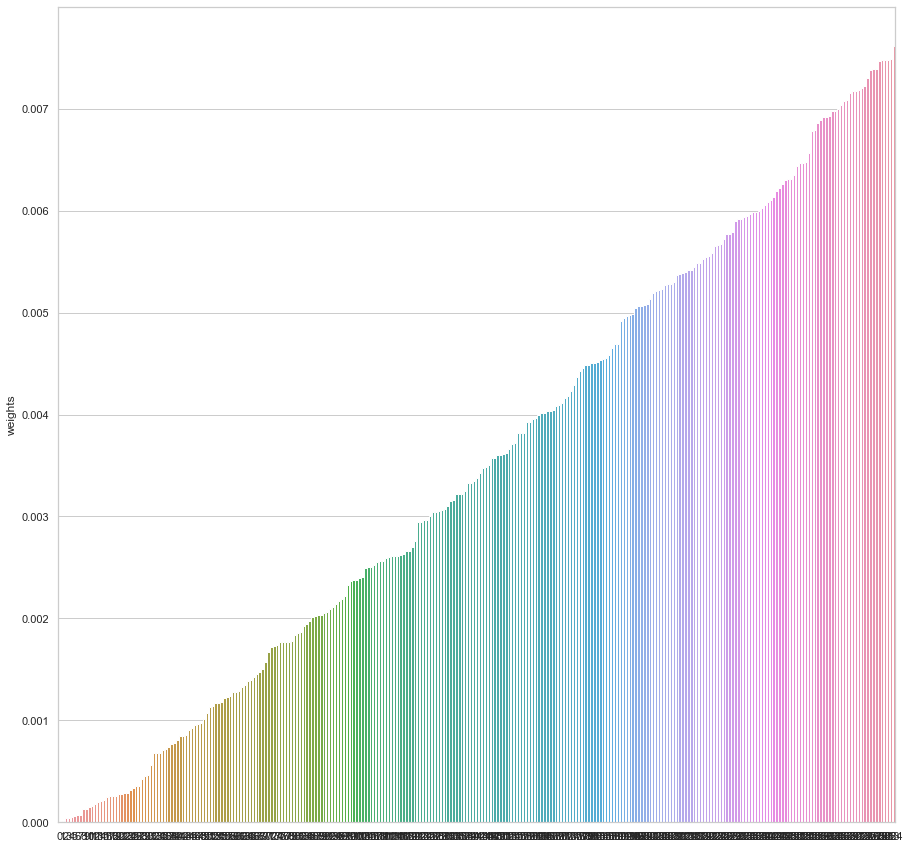

In [136]:
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# # Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot( x=np.array(range(weights.size)), y=df['weights'] )

# **Transactions** <a class="anchor" id="Transactions"></a>

## **Unstaking-Funds** <a class="anchor" id="Unstaking-Funds"></a>

In [110]:
from bittensor.utils.balance import Balance
amount_tao = 0.1
amount = Balance.from_float( amount_tao )
print(colored("Sending Extrinsic: [Unstake: {} Tao from hotkey: {}]".format( amount.tao, wallet.hotkey.public_key) , 'blue'))
print ('waiting for finalization...')
result = bittensor.subtensor.unstake( amount, wallet.hotkey.public_key, wait_for_finalization = True, timeout = bittensor.__blocktime__ * 5)
if result:
    new_balance = bittensor.subtensor.get_balance(wallet.coldkeypub)
    new_stake = bittensor.subtensor.get_stake_for_uid( bittensor.metagraph.uid_for_pubkey(wallet.hotkey.public_key) )
    print(colored("Unstaked: {} Tao from hotkey: {} to coldkey.pub: {}".format( amount.tao, wallet.hotkey.public_key, wallet.coldkey.public_key ) , 'green'))
    print(colored("Your coldkey has new balance: {} Tao".format( new_balance.tao ) , 'green'))
    print(colored("Your hotkey has new stake: {} Tao".format( new_stake.tao ) , 'green'))
else:
    print(colored("Unstaking transaction failed", 'red'))

Sending Extrinsic: [Unstake: 0.1 Tao from hotkey: 0x80cacfbdf7b155b39de22680a7cb14c61a8f95df702c92f5f142d25cca37c545]
waiting for finalization...


Enter password to unlock key:  ··············


decrypting key... (this may take a few moments)
Loaded coldkey: 0x3c9cd1679888e5660b0c8e4b8a17a1719c0cb7f05b5c624a856b421b52290515
Unstaked: 0.1 Tao from hotkey: 0x80cacfbdf7b155b39de22680a7cb14c61a8f95df702c92f5f142d25cca37c545 to coldkey.pub: 0x3c9cd1679888e5660b0c8e4b8a17a1719c0cb7f05b5c624a856b421b52290515
Your coldkey has new balance: 0.2 Tao
Your hotkey has new stake: 112.067646278 Tao


## **Staking-Funds** <a class="anchor" id="Staking-Funds"></a>

In [111]:
from bittensor.utils.balance import Balance 
amount_tao = 0.1
amount = Balance.from_float( amount_tao )
print(colored("Sending Extrinsic: [Stake: {} Tao to hotkey: {}]".format( amount.tao, wallet.hotkey.public_key) , 'blue'))
print ('waiting for finalization...')
result = bittensor.subtensor.add_stake( amount, wallet.hotkey.public_key, wait_for_finalization = True, timeout = bittensor.__blocktime__ * 5)
if result:
  new_balance = bittensor.subtensor.get_balance(wallet.coldkeypub)
  new_stake = bittensor.subtensor.get_stake_for_uid(bittensor.metagraph.uid_for_pubkey(wallet.hotkey.public_key))
  print(colored("Staked: {} Tao to hotkey: {} from coldkey.pub: {}".format( amount.tao, wallet.hotkey.public_key, wallet.coldkey.public_key ) , 'green'))
  print(colored("Your coldkey has new balance: {} Tao".format( new_balance.tao ) , 'green'))
  print(colored("Your hotkey has new stake: {} Tao".format( new_stake.tao ) , 'green'))

else:
  print(colored("Staking transaction failed", 'red'))

Sending Extrinsic: [Stake: 0.1 Tao to hotkey: 0x80cacfbdf7b155b39de22680a7cb14c61a8f95df702c92f5f142d25cca37c545]
waiting for finalization...
Staked: 0.1 Tao to hotkey: 0x80cacfbdf7b155b39de22680a7cb14c61a8f95df702c92f5f142d25cca37c545 from coldkey.pub: 0x3c9cd1679888e5660b0c8e4b8a17a1719c0cb7f05b5c624a856b421b52290515
Your coldkey has new balance: 0.1 Tao
Your hotkey has new stake: 112.170295159 Tao


## **Transfering-Funds** <a class="anchor" id="Transfering-Funds"></a>

In [201]:
amount = 0.01
destination_public_key = wallet.coldkey.public_key
amount = Balance.from_float( amount )
balance = bittensor.subtensor.get_balance( wallet.coldkey.public_key )
if balance < amount:
    print(colored("Not enough balance ({}) to transfer {}".format(balance, amount), 'red'))
    quit()

print(colored("Requesting transfer of {} Tao, from coldkey.pub: {} to dest.pub: {}".format(amount.tao, wallet.coldkey.public_key, destination_public_key), 'blue'))
print("Waiting for finalization...",)
result = bittensor.subtensor.transfer(destination_public_key, amount, wait_for_finalization = True, timeout = bittensor.__blocktime__ * 5)
if result:
    print(colored("Transfer finalized with amount: {} Tao to dest: {} from coldkey.pub: {}".format(amount.tao, destination_public_key, wallet.coldkey.public_key), 'green'))
    new_balance = bittensor.subtensor.get_balance(wallet.coldkeypub)
    destination_balance = bittensor.subtensor.get_balance(destination_public_key)
    print(colored("Your coldkey has new balance: {} Tao".format( new_balance.tao ) , 'green'))
    print(colored("The destination has new balance: {} Tao".format( new_balance.tao ) , 'green'))
else:
    print(colored("Transfer failed", 'red'))

AttributeError: module 'bittensor' has no attribute 'utils'